# Lane Fitting for the ONNX lane detection model output

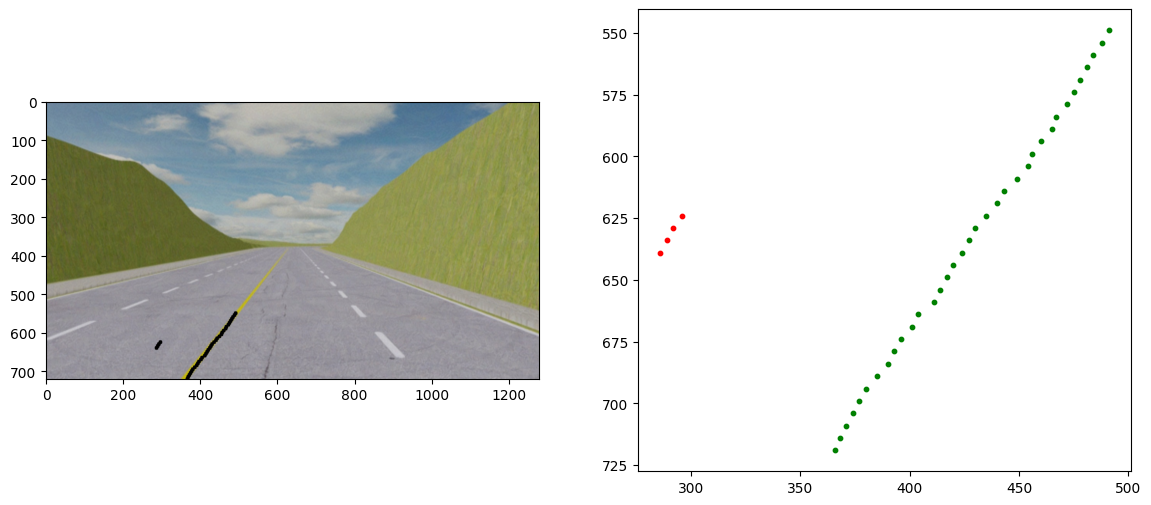

In [4]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
import cv2
import numpy as np
from matplotlib import pyplot as plt
from inference_file import inference
import pytorch_auto_drive.functional as F


# FILENAME = 'example_input_adv_img_fast_gradient.jpg'
FILENAME = 'example_input.jpg'
# results, keypoints = inference(FILENAME, model_path='../../resnet50_resa_tusimple_20211019.onnx')
results, keypoints = inference(FILENAME, model_path='../../resnet50_resa_culane_20211016.onnx')

infered_img = results[0]
keypoints = keypoints[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(infered_img)
ax2.invert_yaxis()

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, lane in enumerate(keypoints):
    for point in lane:
        ax2.scatter(point[0], point[1], s=10, c=colors[i], marker='o')



(720, 1280, 3)


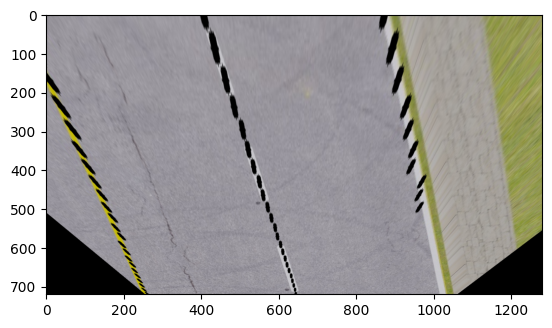

In [2]:
def getTransformMatrix(inpImage):
    # manually selected source and destination points
    print(inpImage.shape)
    src =  np.float32([[470, 500], [800, 500], [inpImage.shape[1]-50, inpImage.shape[0]],  [150, inpImage.shape[0]]])
    line_dst_offset = 200

    dst = np.float32([[src[3][0] + line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, src[2][1]], \
          [src[3][0] + line_dst_offset, src[3][1]]])

    matrix = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    return matrix, minv

def perspectiveWarpImage(inpImage):
    matrix, matrix_inv = getTransformMatrix(inpImage)
   
    birdseye = cv2.warpPerspective(inpImage, matrix, inpImage.shape[0:2][::-1])

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft  = birdseye[0:height, 0:width // 2]
    birdseyeRight = birdseye[0:height, width // 2:width]

    # Display birdseye view image
    plt.imshow(birdseye)
    return birdseye

warped_image = perspectiveWarpImage(infered_img)

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


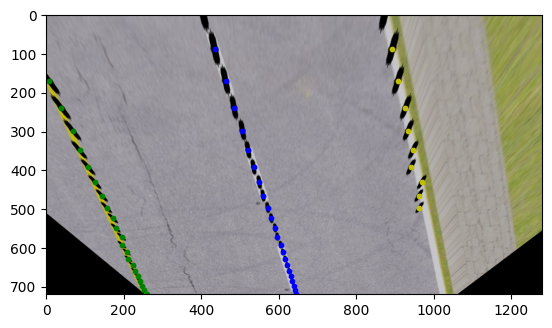

In [3]:
def transformPoint(point, matrix):
    # https://stackoverflow.com/a/57400980
    px = (matrix[0][0]*point[0] + matrix[0][1]*point[1] + matrix[0][2]) / ((matrix[2][0]*point[0] + matrix[2][1]*point[1] + matrix[2][2]))
    py = (matrix[1][0]*point[0] + matrix[1][1]*point[1] + matrix[1][2]) / ((matrix[2][0]*point[0] + matrix[2][1]*point[1] + matrix[2][2]))
    return (px, py)

def perspectiveWarp(keypoints, inpImage):

    colors = ['r', 'g', 'b', 'y', 'c', 'm']

    lanes=[]
    for i, lane in enumerate(keypoints): 
        matrix, matrix_inv = getTransformMatrix(inpImage)

        plt.ylim([0,inpImage.shape[0]])
        plt.xlim([0,inpImage.shape[1]])        
        plt.gca().invert_yaxis()

        result_points = []
        for point in lane:
            point = transformPoint(point, matrix)
            result_points.append(point)
            plt.scatter(point[0], point[1], s=10, c=colors[i], marker='o')

        
        lanes.append(np.float32(result_points))
        
    return lanes

plt.imshow(perspectiveWarpImage(infered_img))
lanes = perspectiveWarp(keypoints, infered_img)

(720, 1280, 3)
(720, 1280, 3)


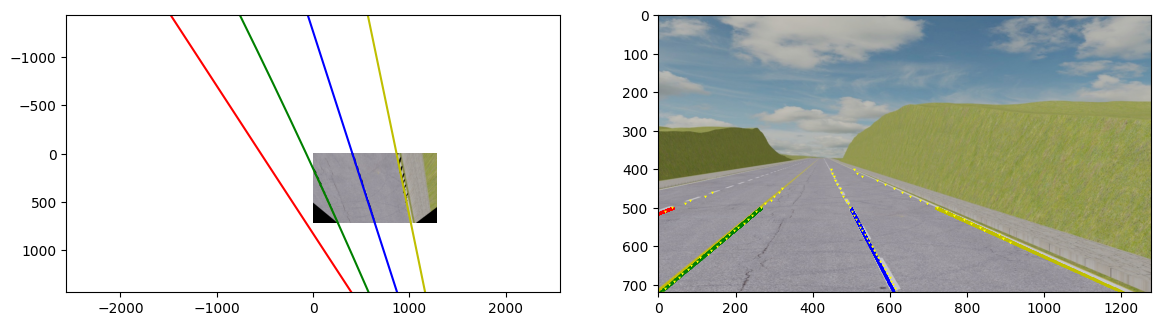

In [4]:
# Lane fitting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.set_xlim([-infered_img.shape[1]*2,infered_img.shape[1]*2])
ax1.set_ylim([-infered_img.shape[0]*2,infered_img.shape[0]*2])
ax1.invert_yaxis()
ax1.imshow(perspectiveWarpImage(infered_img))

colors = ['r', 'g', 'b', 'y', 'c', 'm']
matrix, matrix_inv = getTransformMatrix(infered_img)

lanes_transformed = []
polyonoms = []

for i, lane in enumerate(lanes): 
    polynom = np.polyfit(lane[:,1], lane[:,0], 2) # note that we are fitting for y, x
    polynom_function = np.poly1d(polynom) # we want to predict x values for a given height (y)
    polyonoms.append(polynom_function)

    ax1.invert_yaxis()
    y_range_debug = np.linspace(-infered_img.shape[0]*2, infered_img.shape[0]*2, infered_img.shape[0])   
    x_predictions_debug = polynom_function(y_range_debug)
    ax1.plot(x_predictions_debug, y_range_debug, c = colors[i])
    
    y_range = np.linspace(0, infered_img.shape[0] - 1, infered_img.shape[0])
    x_predictions = polynom_function(y_range)

    lane_points_transformed=[[],[]]
    transform = cv2.perspectiveTransform(np.vstack((x_predictions, y_range)).T[np.newaxis, ...], matrix_inv)
    transform =  [transform[0][:,0], transform[0][:,1]]
    lanes_transformed.append(transform)

from PIL import Image
# overlay the original image
original_img = Image.open(FILENAME)
for i, lane in enumerate(lanes_transformed):
    ax2.scatter(lane[0], lane[1],s=1, c = colors[i], zorder=1)

# print initial keypoints
for lane in keypoints:
    for point in lane:
        ax2.scatter(point[0], point[1], marker="2", color="yellow", s=1, zorder=2)
ax2.imshow(original_img)




[[  37.01406    36.776848   36.539173 ... -513.3791   -515.87494
  -518.3864  ]
 [ 500.        500.09344   500.1871   ...  717.02814   718.0126
   719.0032  ]]
[2, 3]
            2
-7.173e-07 x + 0.2068 x + 867


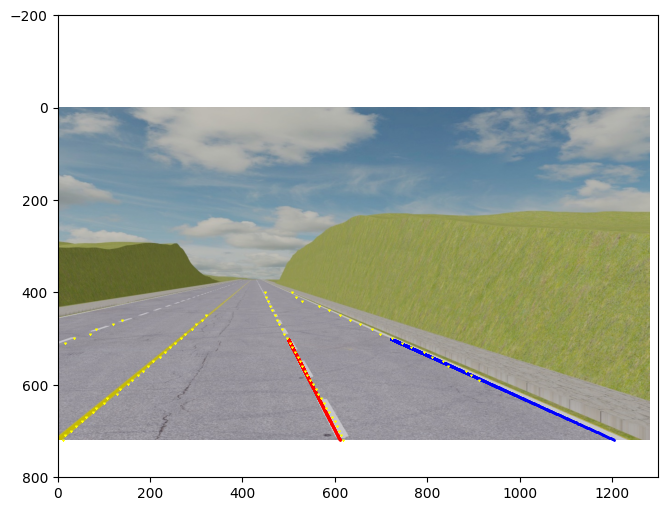

In [5]:
# Ego lane selection

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

ax1.set_xlim([0,1300])
ax1.set_ylim([-200,800])
ax1.invert_yaxis()

left_lane = np.float32(lanes_transformed[0])
right_lane = np.float32(lanes_transformed[len(lanes_transformed)-1])
selected_indices = [0, len(lanes_transformed)-1]
middle = original_img.size[0]/2

print(left_lane)

for i, lane in enumerate(lanes_transformed):
    avg = np.average(lane[0])

    if avg < middle and avg > np.average(left_lane[0]):
        left_lane = np.float32(lane)
        selected_indices[0] = i
        continue

    if avg > middle and avg < np.average(right_lane[0]):
        right_lane = np.float32(lane)
        selected_indices[1] = i
        continue

    
# left_lane = left_lane.T
# left_lane = np.vstack(left_lane[left_lane[:, 0] <= middle, :]).T
left_lane_poly = polyonoms[selected_indices[0]]

# right_lane = right_lane.T
# right_lane = np.vstack(right_lane[right_lane[:, 0] >= middle, :]).T
right_lane_poly = polyonoms[selected_indices[1]]

ax1.scatter(left_lane[0], left_lane[1],s=1, c = 'red', zorder=1)
ax1.scatter(right_lane[0], right_lane[1],s=1, c = 'blue', zorder=1)

for lane in keypoints:
    for point in lane:
        ax1.scatter(point[0], point[1], marker="2", color="yellow", s=2, zorder=2)
ax1.imshow(original_img)

print(selected_indices)
print(right_lane_poly)

(720, 1280, 3)
315.15
RADIUS: -1041.66
Angle: -18.18047897826432 degrees
Curve Direction: Left
Lane Width: 0.048596715330781644 m
Off Center: 0.0199 m


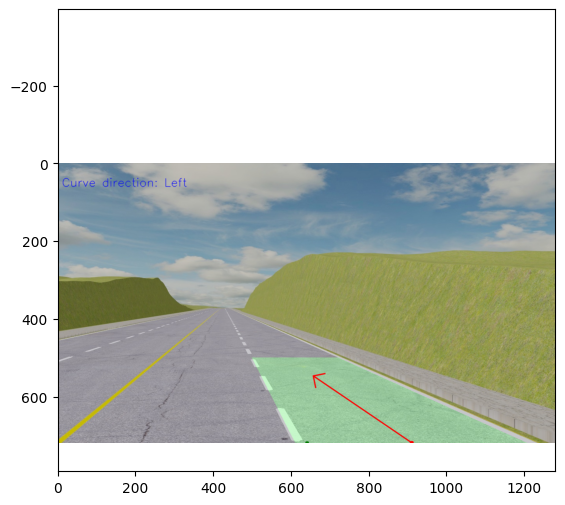

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))
ax1.set_xlim([0,infered_img.shape[1]])
ax1.set_ylim([-infered_img.shape[0]*1.1/2,infered_img.shape[0]*1.1])
ax1.invert_yaxis()

def calculate_radius(image, left_lane_poly, right_lane_poly):
    height = image.height
    width = image.width

    # zeroed_channel = np.zeros_like((height,width)).astype(np.uint8)
    # color_fill_image = np.dstack((zeroed_channel, zeroed_channel, zeroed_channel))
    color_fill_image = np.zeros([height, width, 3])
    image_np = np.array(image)
    matrix, matrix_inv = getTransformMatrix(image_np)   


    y_range = np.linspace(0, height - 1, height)
    left_fit = left_lane_poly(y_range)
    right_fit = right_lane_poly(y_range)
    
    l1 = np.transpose(np.vstack([left_fit, y_range]))
    l2 =np.flip(np.transpose(np.vstack([right_fit, y_range])), axis=0)
    pts = np.int_(np.vstack((l1, l2)))


    color_fill_image = cv2.fillPoly(color_fill_image, [pts], (0, 255, 0))  
    color_fill_image_transformed = cv2.warpPerspective(color_fill_image, matrix_inv, (width, height))
    result = cv2.addWeighted(image_np, 1, color_fill_image_transformed, 0.2, 0, dtype=cv2.CV_8U)


    ### Angle calculation ###

    ym_per_pix = 0.000106  # meters per pixel in y dimension
    xm_per_pix = 0.000106  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(y_range * ym_per_pix, left_fit * xm_per_pix, 2)
    right_fit_cr = np.polyfit(y_range * ym_per_pix, right_fit * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * height * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])

    right_curverad = ((1 + (2 * right_fit_cr[0] * height * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    radius1 = round((float(left_curverad) + float(right_curverad))/2.,2)

    print(radius1)

    if left_fit[0] - left_fit[-1] < -60:
        curve_direction = 'Left'
        radius=-5729.57795/radius1
    elif left_fit[-1] - left_fit[0] > 60:
        curve_direction = 'Right'
        radius=5729.57795/radius1
    else:
        curve_direction = 'Straight'
        radius=5729.57795/radius1

    print(f"RADIUS: {np.rad2deg(radius):.2f}")

    lane_width = (right_lane_poly.coefficients[2] - left_lane_poly.coefficients[2]) * xm_per_pix    

    left_lane_start = left_lane_poly(height)
    right_lane_start = right_lane_poly(height)
    center_x = left_lane_start + (right_lane_start - left_lane_start) / 2
    center_world = transformPoint((center_x, height), matrix_inv)

    off_center = round((center_x - width / 2.) * xm_per_pix,4) # assume camera is in the center of the car

    # draw a point for the center at y=0
    cv2.circle(result, np.int_(center_world), 5, (255, 0, 0), -1) # current center
    cv2.circle(result, np.int_((width/2, height)), 5, (0, 120, 0), -1) # desired center
    
    angle_rad = np.deg2rad(radius -90) # TODO: check if this is correct on a right turn
    end_point = transformPoint((center_x + 400 * np.cos(angle_rad), height + 400 * np.sin(angle_rad)), matrix_inv)

    cv2.arrowedLine(result, np.int_(center_world), np.int_(end_point), (255, 0, 0), 2, cv2.LINE_AA)  
    # cv2.putText(result, f'Steering angle: {radius:.2f} degress', (10, 30), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(result, f'Curve direction: {curve_direction}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 255), 1, cv2.LINE_AA)

    print('Angle:', radius, 'degrees')
    print('Curve Direction:', curve_direction)
    print('Lane Width:', lane_width, 'm') # should match BaseMap.LANE_WIDTH: 3.5
    print('Off Center:', off_center, 'm')

    ax1.imshow(result)

calculate_radius(original_img, left_lane_poly, right_lane_poly)